Device:  cpu


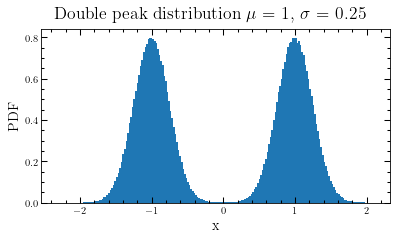

In [2]:
from utils import *

from torch.utils.data import DataLoader
from DiffusionModels import Net, ScoreModel, MarginalProb

import json, os

from tqdm.notebook import tqdm

device = torch.device('cpu')
print("Device: ", device)

mu = 1; sigma = 0.25

samples = np.loadtxt("../data/double_peak_samples_1M.dat", dtype=np.float32)[:, None]

fig, ax = plt.subplots(1, 1, dpi=75, figsize=(6,3))
fig.suptitle(f"Double peak distribution $\mu$ = {mu}, $\sigma$ = {sigma}")
ax.hist(samples, bins=200, density=True)
ax.set_xlabel('x')
ax.set_ylabel('PDF')
plt.show()

In [11]:
marginal_prob_sigma = 10

model_filename = f"../data/ModelWeights/double_peak_sigma{marginal_prob_sigma}_weights2.pt"
param_filename = f"../data/ModelWeights/double_peak_sigma{marginal_prob_sigma}_params2.json"

#Model setup
parameters = {
	'input_channels': 1,
	'marginal_prob_sigma': marginal_prob_sigma,
	'channels': 2*[64],
	'time_channels': 128
}
with open(param_filename, 'w') as fp:
    json.dump(parameters, fp)


input_channels = parameters['input_channels']
marginal_prob_sigma = parameters['marginal_prob_sigma']
channels = parameters['channels']
time_channels = parameters['time_channels']
marginal_prob = MarginalProb(sigma=marginal_prob_sigma)

net = Net(input_channels, channels, time_channels, activation=torch.nn.LeakyReLU(), device=device)
model = ScoreModel(net, marginal_prob, device=device)


# model.load_state_dict(torch.load(f"../data/ModelWeights/double_peak_sigma{marginal_prob_sigma}_weights2.pt"))

if not os.path.exists(model_filename):
	#Score Based Training
	#Training setup
	batch_size = 512; base_lr = 1e-4; N_epochs = 200
	optimizer = torch.optim.Adam(model.parameters(), lr=base_lr)
	scheduler = None #torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
	loader = DataLoader(samples.astype(np.float32), batch_size, shuffle=True, pin_memory=True)
	model.train_v2(loader, optimizer, N_epochs, model_filename, scheduler=scheduler, early_stopping=50)

model.load_state_dict(torch.load(model_filename))

<All keys matched successfully>

In [17]:
size = int(5e5)
num_steps = 1000
init_x = None #np.random.normal(-scaler.mean, 1/scaler.std, size=(size, 1))
dsamples = model.sampler(size, num_steps, history=True, eps=1e-3)

100%|██████████| 1000/1000 [03:36<00:00,  4.61it/s]


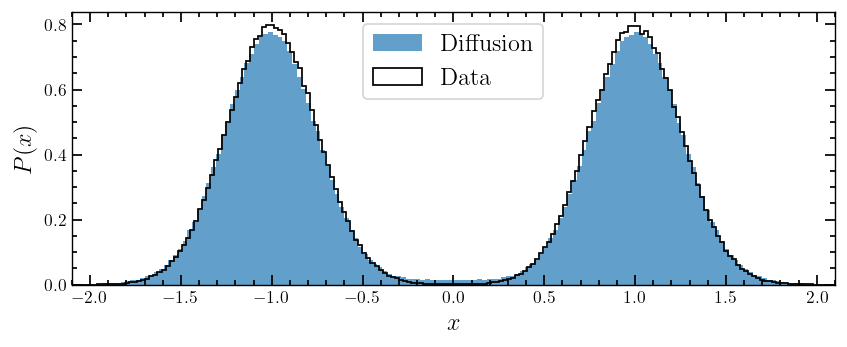

In [18]:
dsamples_ = dsamples.squeeze()
dsamples_ = np.concatenate([dsamples_, -dsamples_], axis=1)
y = dsamples_[-1]; y_d = samples

fig, ax = plt.subplots(1, 1, dpi=125, figsize=(7, 3))
ax.hist(y, density=True, bins=200, label='Diffusion', alpha=0.7)
ax.hist(y_d, density=True, bins=200, label='Data', alpha=1, color='black', histtype='step')

ax.set_xlabel('$x$')
ax.set_ylabel('$P(x)$')
ax.set_xlim(-2.1, 2.1)
plt.legend()
plt.tight_layout()
# plt.show()
# plt.savefig('plot-distribution.pdf')

In [22]:
max_order = 8
order = np.arange(2, max_order + 1, 2)
y = dsamples_[-1]; y_d = samples.squeeze()

exact_c = np.array([1, sigma**2 + mu**2, 1, -2*mu**4, 1, 16 * mu**6, 1, -272 * mu**8])[:max_order]

cumulants, errs = bootstrap_cumulants(y, max_order)
cumulants_d, errs_d = bootstrap_cumulants(y_d, max_order)

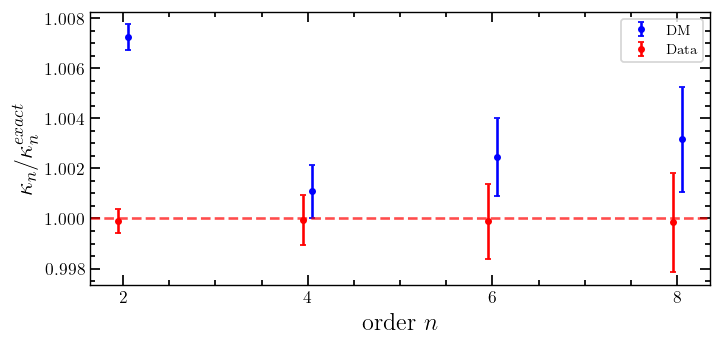

In [23]:
fig, ax = plt.subplots(1, 1, dpi=125, figsize=(6, 3))

ax.errorbar(order+0.05, (cumulants/exact_c)[1::2], (errs/abs(exact_c))[1::2], capsize=2.0, marker='.', ls='', c='blue', label="DM")
ax.errorbar(order-0.05, (cumulants_d/exact_c)[1::2], (errs_d/abs(exact_c))[1::2], capsize=2.0, marker='.', ls='', c='red',label='Data')
ax.axhline(1., ls='--', alpha=0.7, c='red')
ax.set_xticks(order)

ax.set_ylabel(f'$\\kappa_n/\\kappa_n^{{exact}}$')
ax.set_xlabel("order $n$")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()
# fig.savefig("../cumulants_error.pdf")

In [24]:
print(5*"#", " Diffusion τ=1", 5*"#")
for (c,e) in zip(cumulants[1::2], errs[1::2]):
	print(f"{c:.5f} ± {e:.7f}")

print(5*"#", " Data ", 5*"#")
for (c,e) in zip(cumulants_d[1::2], errs_d[1::2]):
	print(f"{c:.5f} ± {e:.7f}")

#####  Diffusion τ=1 #####
1.07019 ± 0.0005380
-2.00217 ± 0.0020981
16.03922 ± 0.0252000
-272.85890 ± 0.5716979
#####  Data  #####
1.06239 ± 0.0005090
-1.99988 ± 0.0019897
15.99815 ± 0.0238498
-271.95733 ± 0.5405949


In [19]:
kappa_history = nth_cumulants(dsamples_[::5], max_order, axis=1)
moment_history = np.squeeze([moment(dsamples_[::5], i, axis=1) for i in order])
kappa = np.squeeze(kappa_history)

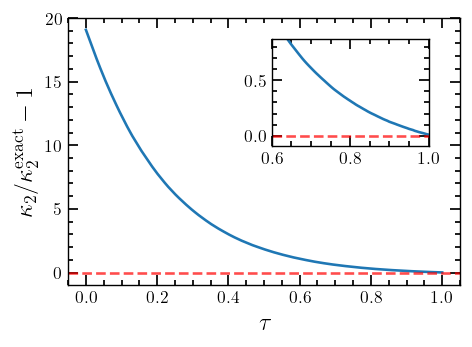

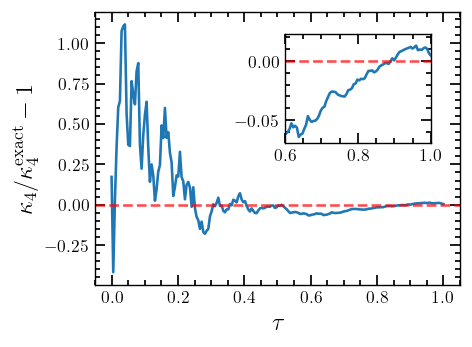

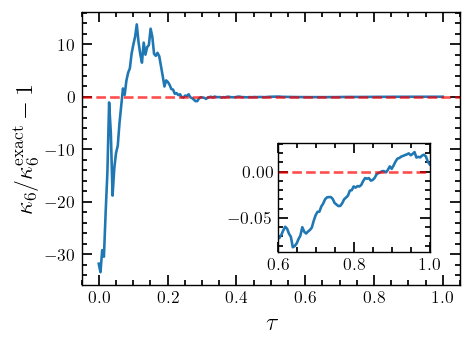

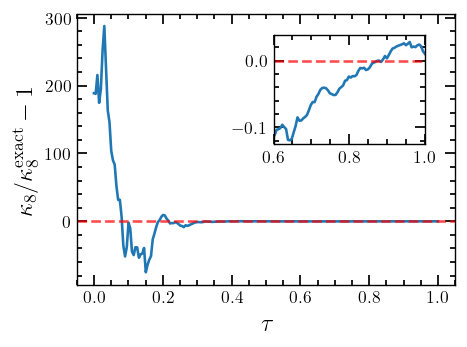

In [21]:
# fig, ax = plt.subplots(1, max_order//2, dpi=125, figsize=(12, 3))
# fig.suptitle("Cumulant evolution in backward process")

dtime = np.linspace(0., 1., kappa.shape[1])
exact_c = np.array([1, sigma**2 + mu**2, 1, -2*mu**4, 1, 16 * mu**6, 1, -272 * mu**8])

y0 = [0.52, 0.52, 0.12, 0.52]
x0 = [0.52, 0.52, 0.52, 0.52]
offsetx = [-0.1, -0.005, -.005, -.005]
offsety = [-0.2, 0.01, .01, .01]
for i in range(max_order//2):
	fig, ax_ = plt.subplots(1, 1, dpi=125, figsize=(4, 3))

	c = kappa[2*i + 1]/exact_c[2*i+1] - 1
	ax_.plot(dtime, c, label="DM")
	ax_.axhline(0., ls='--', alpha=0.7, c='red')
	ax_.set_ylabel(f'$\\kappa_{(i+1) * 2}/\\kappa_{(i+1) * 2}^{{\\mathrm{{exact}}}}-1$')
	ax_.set_xlabel("$\\tau$")

	subset_mask = (dtime > 0.6) & (dtime <= 1.)
	# Adding the inset
	inset_ax = ax_.inset_axes([x0[i], y0[i], 0.4, 0.4])  # [x0, y0, width, height] in relative coordinates
	inset_ax.plot(dtime[subset_mask], c[subset_mask])
	inset_ax.axhline(0., ls='--', alpha=0.7, c='red')
	inset_ax.set_xlim(0.6, 1.0)
	inset_ax.set_ylim(min(c[subset_mask]) + offsetx[i], max(c[subset_mask]) + offsety[i])
	plt.tight_layout()
	# plt.legend()
	# plt.show()
	# plt.savefig(f'../new_figures/cumulant{2 * (i + 1)}_bw_diffusion.pdf')

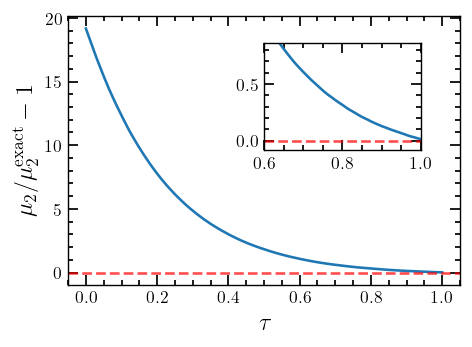

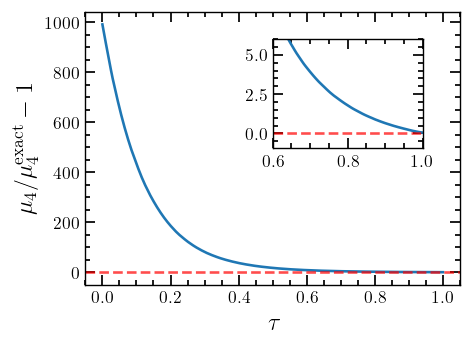

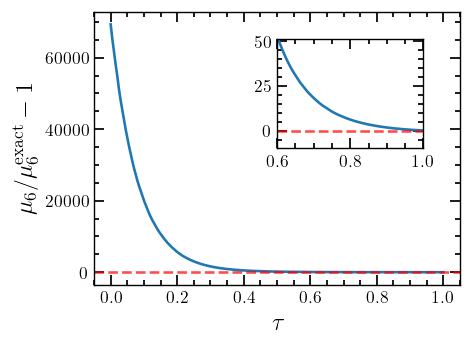

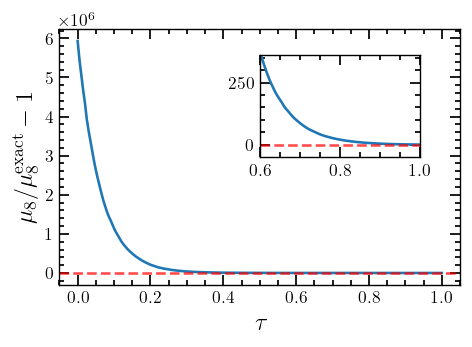

In [67]:
dtime = np.linspace(0., 1., kappa.shape[1])
exact_m = [
	sigma**2 + mu**2,
	3 * sigma**4 + 6 * sigma**2 * mu**2 + mu**4, 
	15 * sigma**6 + 45 * sigma**4 * mu**2 + 15*sigma**2 * mu**4 + mu**6,
	105 * sigma**8 + 420 * sigma**6 * mu**2 + 210 * sigma **4 * mu**4 + 28 * sigma**2 * mu**6 + mu**8
	]

y0 = [0.5, 0.5, 0.5, 0.5]
x0 = [0.5, 0.5, 0.5, 0.5]
offsetx = [-0.1, -1, -10, -50]
offsety = [-0.2, -2., -0.2, -0.2]
for i in range(max_order//2):
	fig, ax_ = plt.subplots(1, 1, dpi=125, figsize=(4, 3))

	c = moment_history[i]/exact_m[i] - 1
	ax_.plot(dtime, c, label="DM")
	ax_.axhline(0., ls='--', alpha=0.7, c='red')
	ax_.set_ylabel(f'$\\mu_{(i+1) * 2}/\\mu_{(i+1) * 2}^{{\\mathrm{{exact}}}} - 1$')
	ax_.set_xlabel("$\\tau$")

	subset_mask = (dtime > 0.6) & (dtime <= 1.)
	# Adding the inset
	inset_ax = ax_.inset_axes([x0[i], y0[i], 0.4, 0.4])  # [x0, y0, width, height] in relative coordinates
	inset_ax.plot(dtime[subset_mask], c[subset_mask])
	inset_ax.axhline(0., ls='--', alpha=0.7, c='red')
	inset_ax.set_xlim(0.6, 1.0)
	inset_ax.set_ylim(min(c[subset_mask]) + offsetx[i], max(c[subset_mask]) + offsety[i])
	plt.tight_layout()
	legend_loc = "lower right" if i==0 else "upper right"
	# plt.legend(fontsize=8, loc=legend_loc)
	# plt.show()
	plt.savefig(f'../new_figures/moment{2 * (i + 1)}_bw_diffusion.pdf')

In [32]:
def analytical_score(x, t, mu=1, sigma=0.25):
	s = sigma**2 + diffusion_std(t)**2
	return - x/s + (mu/s) * np.tanh(x * mu/s) 
 
def diffusion_std(t):
	logsigma = 2 * np.log(10)
	return np.sqrt((10 ** (2 * t) - 1)/logsigma)

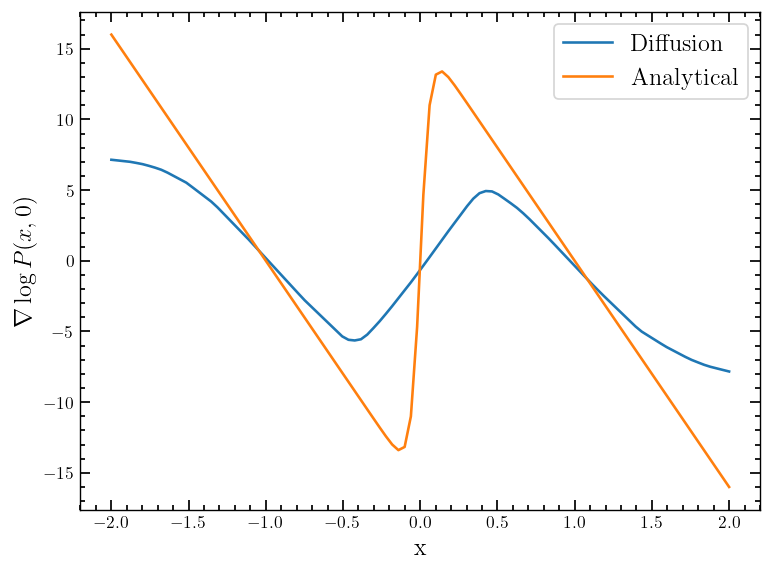

In [35]:
# plt.plot(analytical_score(0, dtime))

t_ = torch.tensor([1e-5], device=device)
z_ = torch.linspace(-2, 2, 100, device=device)[:, None]

fig, ax = plt.subplots(1, 1, dpi=125)

f = grab(model.forward(z_, t_))
f_analytical = analytical_score(grab(z_), grab(t_))

ax.plot(grab(z_), f[:], label='Diffusion')
ax.plot(grab(z_), f_analytical, label='Analytical')
ax.set_xlabel('x')
ax.set_ylabel('$\\nabla\log P(x, 0)$')

plt.legend()
plt.tight_layout()
plt.show()